In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
from typing import Union, Optional, Type, Tuple, List, Dict
import sys
from skimage.color import label2rgb
import json
# import nrrd

import pandas as pd
import seaborn as sns
# Project Root
# used for searching packages and functions
# TODO: enter your project root dir here
ROOT_DIR = '/project/Xie_Lab/zgu/xiao_multiplex/multiTAP/image_cytof'

sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'image_cytof'))
from cytof.hyperion_preprocess import cytof_read_data_roi
from cytof.utils import save_multi_channel_img, check_feature_distribution
from cytof.classes import CytofImageTiff
from cytof.classes import CytofCohort

/project/Xie_Lab/zgu/conda_stuff/envs/cytof-shared/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def flatten_coexpression_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flattens a symmetric co-expression matrix (including the diagonal)
    into a single-row wide-format DataFrame.
    
    Parameters:
        df (pd.DataFrame): A square symmetric DataFrame of co-expression values.
        
    Returns:
        pd.DataFrame: A single-row wide-format DataFrame where each column is a
                      unique pair (e.g., 'GeneA_GeneB') and the value is the
                      corresponding co-expression score.
    """
    if df.shape[0] != df.shape[1]:
        raise ValueError("Input DataFrame must be square.")
    if not df.columns.equals(df.index):
        raise ValueError("DataFrame must have matching row and column labels.")

    # Get upper triangle indices (including diagonal)
    mask = np.triu(np.ones(df.shape), k=0).astype(bool)
    i, j = np.where(mask)

    # Build column names and extract values
    colnames = [f"{df.index[r]}_{df.columns[c]}" for r, c in zip(i, j)]
    values = df.values[i, j]

    # Return as single-row wide-format DataFrame
    return pd.DataFrame([values], columns=colnames)


In [4]:
batch_pt_slides_path = '/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group0/nsclc_save_group0.pkl'
cytof_cohort_whole_slide = pkl.load(open(batch_pt_slides_path, 'rb'))

In [5]:
cytof_cohort_whole_slide.cytof_images.keys()

dict_keys(['NSCLC_ALL_86_A_A1_1', 'NSCLC_ALL_86_A_A1_2', 'NSCLC_ALL_86_A_A1_5', 'NSCLC_ALL_86_A_A1_6', 'NSCLC_ALL_86_A_A1_7', 'NSCLC_ALL_86_A_A1_8', 'NSCLC_ALL_86_A_A1_9', 'NSCLC_ALL_86_A_A1_10', 'NSCLC_ALL_86_A_A1_11', 'NSCLC_ALL_86_A_A1_13', 'NSCLC_ALL_86_A_A1_14', 'NSCLC_ALL_86_A_A2_1', 'NSCLC_ALL_86_A_A2_2', 'NSCLC_ALL_86_A_A2_3', 'NSCLC_ALL_86_A_A2_4', 'NSCLC_ALL_86_A_A2_5', 'NSCLC_ALL_86_A_A2_6', 'NSCLC_ALL_86_A_A2_7', 'NSCLC_ALL_86_A_A2_8', 'NSCLC_ALL_86_A_A2_9', 'NSCLC_ALL_86_A_A2_10', 'NSCLC_ALL_86_A_A2_11', 'NSCLC_ALL_86_A_A2_12', 'NSCLC_ALL_86_A_A2_13', 'NSCLC_ALL_86_A_A2_14', 'NSCLC_ALL_86_A_A3_2', 'NSCLC_ALL_86_A_A3_3', 'NSCLC_ALL_86_A_A3_5', 'NSCLC_ALL_86_A_A3_6', 'NSCLC_ALL_86_A_A3_8', 'NSCLC_ALL_86_A_A3_9', 'NSCLC_ALL_86_A_A3_10', 'NSCLC_ALL_86_A_A3_11', 'NSCLC_ALL_86_A_A3_12', 'NSCLC_ALL_86_A_A3_13', 'NSCLC_ALL_86_A_A3_14', 'NSCLC_ALL_86_A_A4_2', 'NSCLC_ALL_86_A_A4_4', 'NSCLC_ALL_86_A_A4_5', 'NSCLC_ALL_86_A_A4_7', 'NSCLC_ALL_86_A_A4_8', 'NSCLC_ALL_86_A_A4_9', 'NSCLC_AL

In [6]:
pt_list = ['NSCLC_ALL_86_A_A1_1', 'NSCLC_ALL_86_A_A1_2', 'NSCLC_ALL_86_A_A1_5']

In [7]:
# preprocessing setup
# pt_name = 'NSCLC_ALL_86_A_A1_1'
df_feature_name = 'df_feature_75normed'
accumul_type = 'sum'
flat_marker_pt_list = []

for pt_name in pt_list:
    # extract individual patients
    ind_cytof_img = cytof_cohort_whole_slide.cytof_images[pt_name]
    df_feat = getattr(ind_cytof_img, df_feature_name)
    marker_col_all = [x for x in df_feat.columns if f"cell_{accumul_type}" in x]
    df_cell_sum = df_feat[marker_col_all]

    # get the marker threshold (marker1, markers, ... vs. positive counts, thresholds)
    ind_cytof_img.calculate_quantiles(qs=[75])

    # still need to process features through a batch
    # more likely, the cohort will contain multiple ROIs. Then user will batch process and generate feature summary
    # after summaries are attached to individual ROIs, eahc cytof_img can be called with co-expression-analysis
    cytof_cohort_of_one = CytofCohort(cytof_images={f'pt_name':ind_cytof_img})
    cytof_cohort_of_one.batch_process_feature()
    cytof_cohort_of_one.generate_summary()

    # calling the individual ROI co-expression-analysis
    # df_co_pos_prob, df_expected_prob = cytof_img_ind_test.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)
    df_co_pos_prob, df_expected_prob = ind_cytof_img.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)

    epsilon = 1e-6 # avoid divide by 0 or log(0)

    # keep the df labels to calculate edges
    df_edge_perc = np.log10(df_co_pos_prob / (df_expected_prob+epsilon) + epsilon)
    df_edge_perc[df_edge_perc == np.log10(epsilon)] = 0

    per_pt_flat_df = flatten_coexpression_matrix(df_edge_perc)

    flat_marker_pt_list.append(per_pt_flat_df)


dict quantiles: {75: 90.62749099731445}
dir_out: ./ <class 'str'>
Output folder created: ./cohort1
dict quantiles in batch process: {75: 90.62749099731445}
Getting thresholds for cell sum of all markers.
dict quantiles: {75: 78.07717895507812}
dir_out: ./ <class 'str'>
Output folder created: ./cohort1
dict quantiles in batch process: {75: 78.07717895507812}
Getting thresholds for cell sum of all markers.
dict quantiles: {75: 70.8807144165039}
dir_out: ./ <class 'str'>
Output folder created: ./cohort1
dict quantiles in batch process: {75: 70.8807144165039}
Getting thresholds for cell sum of all markers.


KeyboardInterrupt: 

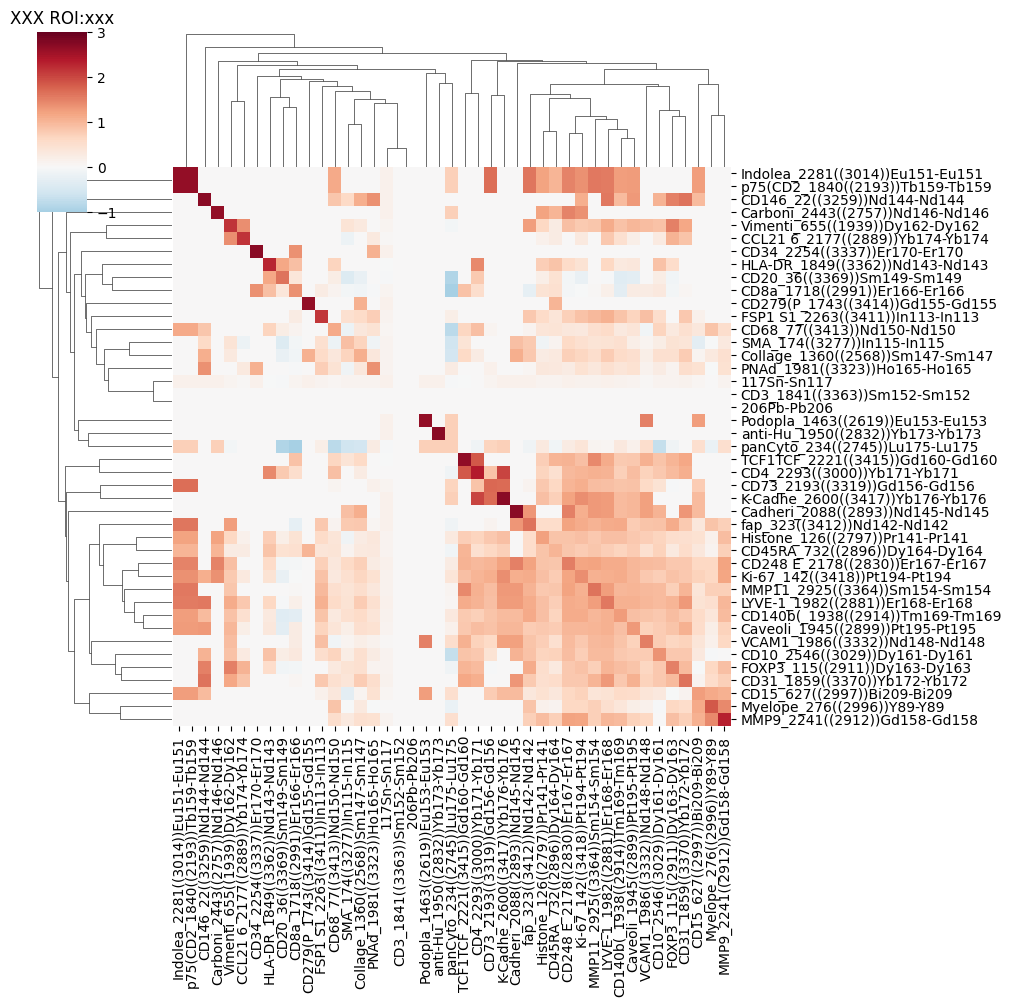

In [73]:
%matplotlib inline
# calling the individual ROI co-expression-analysis
# df_co_pos_prob, df_expected_prob = cytof_img_ind_test.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)
df_co_pos_prob, df_expected_prob = ind_cytof_img.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)

epsilon = 1e-6 # avoid divide by 0 or log(0)

# Normalize and fix Nan
edge_percentage_norm = np.log10(df_co_pos_prob.values / (df_expected_prob.values+epsilon) + epsilon)

# if observed/expected = 0, then log odds ratio will have log10(epsilon)
# no observed means co-expression cannot be determined, does not mean strong negative co-expression
edge_percentage_norm[edge_percentage_norm == np.log10(epsilon)] = 0

# do some post processing
marker_all_clean = [m.replace('_cell_sum', '') for m in df_expected_prob.columns]


# fig = plt.figure()
clustergrid = sns.clustermap(edge_percentage_norm,
                # clustergrid = sns.clustermap(edge_percentage_norm,
                center=np.log10(1 + epsilon), cmap='RdBu_r', vmin=-1, vmax=3,
                xticklabels=marker_all_clean, yticklabels=marker_all_clean)

# plt.title(f'{one_slide} ROI:{one_roi}')
plt.title(f'XXX ROI:xxx')

# plt.savefig('figure4a.pdf', format='pdf', dpi=300, bbox_inches='tight') # tight to save all edges of the figure
plt.show()

In [64]:
combined_df = pd.concat(flat_marker_pt_list, axis=0, ignore_index=True)
combined_df

,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_Ki-67_142((3418))Pt194-Pt194_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum
0,2.389949,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.543261,1.365713,0.968170,0.656991,2.110415,0.935796,0.531200,2.016158,0.832462,1.310333
1,2.525314,0.0,0.000000,0.049678,0.000000,0.000000,0.941484,0.956723,0.0,1.053351,...,1.218091,0.955255,1.088464,0.611343,1.163134,1.034049,0.000000,2.665892,0.000000,2.665892
2,1.871431,0.0,-0.005308,0.019321,0.144955,0.851278,0.000000,0.000000,0.0,0.000000,...,1.390479,0.999691,0.000000,0.695943,1.294854,0.000000,0.554505,0.000000,0.000000,1.258287


In [65]:
pt_name

'NSCLC_ALL_86_A_A1_5'

In [66]:
roi_id_list = []
for pt in pt_list:
    split = pt.split('_')
    roi_id_matched = f"{split[2]}_{split[4]},{split[5]}"
    roi_id_list.append(roi_id_matched)

roi_id_list

['86_A1,1', '86_A1,2', '86_A1,5']

In [13]:
pt_clinical_data = pd.read_csv('/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/clinical_data_ROI.csv')
# pt_subset = pt_clinical_data[pt_clinical_data['RoiID'].isin(roi_id_list)]
pt_subset = pt_clinical_data[['RoiID', 'OS', 'Ev.O', 'Relapse', 'DFS', 'Smok', 'Patient_ID']]
# pt_subset['OS_one_Year'] = pt_subset['OS'] > 365

# first exclude control from analysis
pt_subset = pt_subset[pt_subset['Patient_ID'] != 'Control']
pt_subset

,RoiID,OS,Ev.O,Relapse,DFS,Smok,Patient_ID
0,"175_A1,1",254.0,1.0,NaN,NaN,3.0,175_1
1,"175_A1,2",3420.0,1.0,0.0,3420.0,1.0,175_5
2,"175_A1,3",1312.0,1.0,0.0,1312.0,1.0,175_9
3,"175_A1,4",1950.0,1.0,0.0,1950.0,3.0,175_13
4,"175_A1,6",820.0,1.0,0.0,820.0,3.0,175_21
...,...,...,...,...,...,...,...
2065,"88_C8,9",596.0,1.0,1.0,370.0,1.0,88_521
2066,"88_C8,10",323.0,1.0,0.0,323.0,0.0,88_525
2067,"88_C8,11",1707.0,0.0,0.0,1707.0,1.0,88_529
2068,"88_C8,12",1652.0,0.0,0.0,1652.0,1.0,88_533


In [16]:
# Count occurrences of each Patient_ID
counts = pt_subset['Patient_ID'].value_counts()

# Convert to DataFrame
counts_df = counts.reset_index()
counts_df.columns = ['Patient_ID', 'Count']
patient_order = counts.index.tolist()  # list of Patient_ID sorted by count descending

# Convert Patient_ID column to categorical with this order to sort accordingly
pt_subset['Patient_ID'] = pd.Categorical(pt_subset['Patient_ID'], categories=patient_order, ordered=True)

# Sort the dataframe by Patient_ID categorical order
sorted_df = pt_subset.sort_values('Patient_ID')
small_sorted = sorted_df.head(10)
small_sorted

,RoiID,OS,Ev.O,Relapse,DFS,Smok,Patient_ID
1779,"88_A4,2",2659.0,0.0,0.0,2659.0,1.0,88_363
1765,"88_A3,2",2659.0,0.0,0.0,2659.0,1.0,88_363
1851,"88_A4,2",2659.0,0.0,0.0,2659.0,1.0,88_363
1321,"86_C3,12",568.0,1.0,1.0,NaN,3.0,86_158
1331,"86_C4,12",568.0,1.0,1.0,NaN,3.0,86_158
1361,"87_A1,9",1039.0,1.0,0.0,1039.0,3.0,87_194
1378,"87_A2,9",1039.0,1.0,0.0,1039.0,3.0,87_194
1363,"87_A1,11",1068.0,1.0,1.0,367.0,1.0,87_202
1380,"87_A2,11",1068.0,1.0,1.0,367.0,1.0,87_202
1344,"86_C7,4",332.0,0.0,1.0,332.0,1.0,86_128


In [32]:
# among the pt that have multiple TMA, check OS, DFS, Ev.O are consistent within each pt
columns_to_check = ['OS', 'Ev.O', 'Relapse', 'DFS', 'Smok']  

# for each pt check # of unique elements in those columns
consistency_df = sorted_df.groupby('Patient_ID')[columns_to_check].nunique()

# each column should only have one
consistency_df['all_consistent'] = (consistency_df <= 1).all(axis=1)

# # get those not consistent
inconsistent_pt = consistency_df[~consistency_df['all_consistent']].reset_index()['Patient_ID']
inconsistent_pt

Series([], Name: Patient_ID, dtype: category
Categories (1070, object): ['88_363' < '86_158' < '87_194' < '87_202' ... '86_145' < '86_149' < '178_530' < '87_250'])

In [33]:
sorted_df[sorted_df['Patient_ID'].isin(inconsistent_pt)]

,RoiID,OS,Ev.O,Relapse,DFS,Smok,Patient_ID


In [8]:
np.unique(pt_subset['Ev.O'], return_counts=True)
np.unique(pt_subset['Smok'], return_counts=True)
len(np.unique(pt_subset['Patient_ID']))

1071

In [68]:
combined_df['OS_one_Year'] = pt_subset['OS_one_Year'].values
combined_df

,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,OS_one_Year
0,2.389949,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.365713,0.968170,0.656991,2.110415,0.935796,0.531200,2.016158,0.832462,1.310333,True
1,2.525314,0.0,0.000000,0.049678,0.000000,0.000000,0.941484,0.956723,0.0,1.053351,...,0.955255,1.088464,0.611343,1.163134,1.034049,0.000000,2.665892,0.000000,2.665892,False
2,1.871431,0.0,-0.005308,0.019321,0.144955,0.851278,0.000000,0.000000,0.0,0.000000,...,0.999691,0.000000,0.695943,1.294854,0.000000,0.554505,0.000000,0.000000,1.258287,False


In [70]:
from sklearn.linear_model import LogisticRegression

# Select features (co-expression values) and binary outcome
X = combined_df.drop(columns=['OS_one_Year'])  # or 'survived_1yr'
y = combined_df['OS_one_Year']  # or 'survived_1yr'

# Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)



LogisticRegression(max_iter=1000)

In [71]:
# Get feature coefficients
coef = model.coef_[0]
feature_importance = pd.Series(coef, index=X.columns)

# Sort by absolute value to see strongest effects
feature_importance_abs = feature_importance.abs().sort_values(ascending=False)
print("Top features by absolute coefficient (unregularized):")
print(feature_importance_abs.head(10))

Top features by absolute coefficient (unregularized):
p75(CD2_1840((2193))Tb159-Tb159_cell_sum_p75(CD2_1840((2193))Tb159-Tb159_cell_sum    0.052324
117Sn-Sn117_cell_sum_117Sn-Sn117_cell_sum                                            0.049987
FSP1 S1_2263((3411))In113-In113_cell_sum_K-Cadhe_2600((3417))Yb176-Yb176_cell_sum    0.049932
Podopla_1463((2619))Eu153-Eu153_cell_sum_CD34_2254((3337))Er170-Er170_cell_sum       0.047473
FSP1 S1_2263((3411))In113-In113_cell_sum_Indolea_2281((3014))Eu151-Eu151_cell_sum    0.044211
Indolea_2281((3014))Eu151-Eu151_cell_sum_K-Cadhe_2600((3417))Yb176-Yb176_cell_sum    0.042148
Podopla_1463((2619))Eu153-Eu153_cell_sum_CD279(P_1743((3414))Gd155-Gd155_cell_sum    0.041359
Podopla_1463((2619))Eu153-Eu153_cell_sum_Vimenti_655((1939))Dy162-Dy162_cell_sum     0.040346
VCAM1_1986((3332))Nd148-Nd148_cell_sum_CD20_36((3369))Sm149-Sm149_cell_sum           0.039529
117Sn-Sn117_cell_sum_FOXP3_115((2911))Dy163-Dy163_cell_sum                           0.038305
dtype:

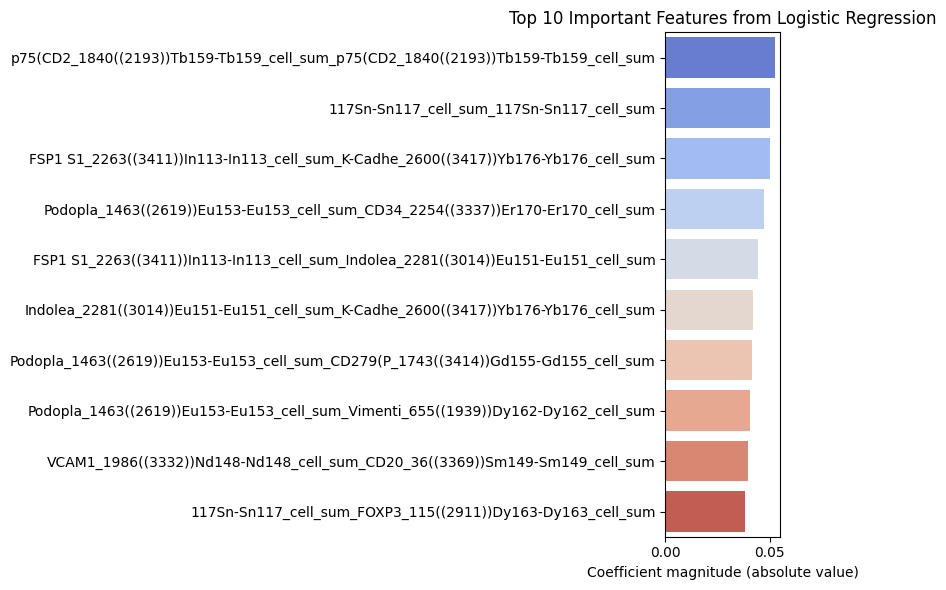

In [72]:
# Select top 10 features by absolute coefficient value
top_features = feature_importance_abs.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')

plt.xlabel('Coefficient magnitude (absolute value)')
plt.title('Top 10 Important Features from Logistic Regression')
plt.tight_layout()
plt.show()

In [23]:
# Example symmetric co-expression matrix
df = pd.DataFrame({
    'GeneA': [1.0, 0.8, 0.5],
    'GeneB': [0.8, 1.0, 0.6],
    'GeneC': [0.5, 0.6, 1.0]
}, index=['GeneA', 'GeneB', 'GeneC'])

# Get upper triangle indices (including diagonal)
mask = np.triu(np.ones(df.shape), k=0).astype(bool)
i, j = np.where(mask)

# Build column names and values
colnames = [f"{df.index[r]}_{df.columns[c]}" for r, c in zip(i, j)]
values = df.values[i, j]

# Create wide-format DataFrame
flat_df = pd.DataFrame([values], columns=colnames)
flat_df

,GeneA_GeneA,GeneA_GeneB,GeneA_GeneC,GeneB_GeneB,GeneB_GeneC,GeneC_GeneC
0,1.0,0.8,0.5,1.0,0.6,1.0
